In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix




##Download source 
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=msnayana&logNo=220917297905

In [16]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = path + '/' + kind + '-labels-idx1-ubyte.gz'
    images_path = path + '/' + kind + '-images-idx3-ubyte.gz'
    print(labels_path)
    print(images_path)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [17]:
def forward(x, w1, b1, w2, b2):
    # Input to hidden
    z1 = np.dot(x, w1) + b1
    a1 = np.maximum(0, z1)  # ReLU activation
    # Hidden to output
    z2 = np.dot(a1, w2) + b2
    exp_z2 = np.exp(z2)
    probs = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)  # Softmax activation
    return a1, probs

def backward(x, y, a1, probs, w2):
    delta3 = probs
    delta3[range(len(x)), y] -= 1
    # Hidden to output
    dw2 = np.dot(a1.T, delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    # Input to hidden
    delta2 = np.dot(delta3, w2.T)
    delta2[a1 <= 0] = 0  # ReLU gradient
    dw1 = np.dot(x.T, delta2)
    db1 = np.sum(delta2, axis=0)
    return dw1, db1, dw2, db2

def cross_entropy_loss(y_pred, y_true):
    # y_pred is the predicted output from the model (shape: (batch_size, num_classes))
    # y_true is the true label of each example in the batch (shape: (batch_size,))
    
    batch_size = y_pred.shape[0]
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # clip probabilities (Limt the values from Min to max range only) to avoid numerical instability
    
    # convert true label to one-hot encoding
    y_true_onehot = np.zeros_like(y_pred)
    y_true_onehot[np.arange(batch_size), y_true] = 1 #place 1 for one hot at only the column position where y_true index is available
    
    # calculate cross entropy loss
    ce_loss = -np.sum(y_true_onehot * np.log(y_pred)) / batch_size
    
    return ce_loss


   

def plot_learning_loss_curve(num_epochs, losses):
    #plt.plot(range(1, num_epochs+1), train_acc, label='Training')
    #plt.plot(range(1, num_epochs+1), test_acc, label='Testing')
    plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_train_validataion_acc_curve(num_epochs, train_acc, test_acc):
    plt.plot(range(1, num_epochs+1), train_acc, label='Training')
    plt.plot(range(1, num_epochs+1), test_acc, label='Testing')
    plt.ylim([0, 1])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
# Define function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) #Create color code image using imshow function
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt =  'd' #'.2f'
    thresh = cm.max() / 2  
    #Iterates over each cell in the confusion matrix
    for i, j in np.ndindex(cm.shape):
        #color of the text is set to white if the cell value is above half the maximum value in the matrix
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def precision_recall_f1(confusion_matrix):
    """
    Compute precision, recall, and F1 score from a confusion matrix.

    Args:
        confusion_matrix: a 2D NumPy array representing the confusion matrix.

    Returns:
        A tuple (precision, recall, f1_score) containing the precision, recall,
        and F1 score for each class, computed from the confusion matrix.
    """
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp

        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    return (precision, recall, f1_score)

def plot_precision_curve(precision, recall, f1_score):
    plt.plot(range(0, 10), precision, label='Precision')
    plt.plot(range(0, 10), recall, label='Recall')
    plt.plot(range(0, 10), f1_score, label='F1 Score')
    plt.ylim([0.85, 1])
    plt.xticks(range(0,10))
    plt.xlabel('Class')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()
    


In [18]:
x_train, y_train = load_mnist('/home/perm/example/mnist/data1', kind='train')
x_test, y_test = load_mnist('/home/perm/example/mnist/data1', kind='t10k')
print(f"X_train.shape: {x_train.shape} Y_train shape: {y_train.shape}")
print(f"X_test.shape: {x_test.shape} Y_test shape: {x_test.shape}")

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

print("X train first example",x_train.shape)
print("Y train shape", y_train.shape)

/home/perm/example/mnist/data1/train-labels-idx1-ubyte.gz
/home/perm/example/mnist/data1/train-images-idx3-ubyte.gz
/home/perm/example/mnist/data1/t10k-labels-idx1-ubyte.gz
/home/perm/example/mnist/data1/t10k-images-idx3-ubyte.gz
X_train.shape: (60000, 784) Y_train shape: (60000,)
X_test.shape: (10000, 784) Y_test shape: (10000, 784)
X train first example (60000, 784)
Y train shape (60000,)


#Let's initialize the weights and biases:



In [19]:
# Network architecture
input_size = 784
hidden_size = 64
output_size = 10

# Hyperparameters
learning_rate = 0.001
batch_size = 128
num_epochs = 100

# Initialize weights and biases
w1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
b1 = np.zeros((1, hidden_size))
w2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
b2 = np.zeros((1, output_size))
# Initialize Adam optimizer
m_w1, v_w1 = np.zeros_like(w1), np.zeros_like(w1) #mean and variance 
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_w2, v_w2 = np.zeros_like(w2), np.zeros_like(w2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
beta1 = 0.9 #Decay factor
beta2 = 0.999 
eps = 1e-8  # set epsilon to 1e-8



##First Moement Calculation:
mt = beta1 * mt-1 + (1 – beta1) * Gt

#Start training the network

Epoch 1/100, accuracy = 0.9173
Epoch 1/100, train accuracy = 0.9134, test accuracy = 0.9173
Epoch 2/100, accuracy = 0.9354
Epoch 2/100, train accuracy = 0.9345, test accuracy = 0.9354
Epoch 3/100, accuracy = 0.9428
Epoch 3/100, train accuracy = 0.9429, test accuracy = 0.9428
Epoch 4/100, accuracy = 0.9536
Epoch 4/100, train accuracy = 0.9554, test accuracy = 0.9536
Epoch 5/100, accuracy = 0.9572
Epoch 5/100, train accuracy = 0.9614, test accuracy = 0.9572
Epoch 6/100, accuracy = 0.9608
Epoch 6/100, train accuracy = 0.9657, test accuracy = 0.9608
Epoch 7/100, accuracy = 0.9645
Epoch 7/100, train accuracy = 0.9683, test accuracy = 0.9645
Epoch 8/100, accuracy = 0.9664
Epoch 8/100, train accuracy = 0.9715, test accuracy = 0.9664
Epoch 9/100, accuracy = 0.9677
Epoch 9/100, train accuracy = 0.9729, test accuracy = 0.9677
Epoch 10/100, accuracy = 0.9692
Epoch 10/100, train accuracy = 0.9748, test accuracy = 0.9692
Epoch 11/100, accuracy = 0.9665
Epoch 11/100, train accuracy = 0.9767, test ac

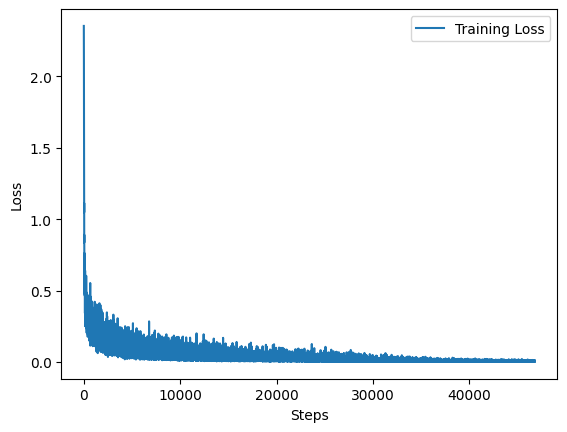

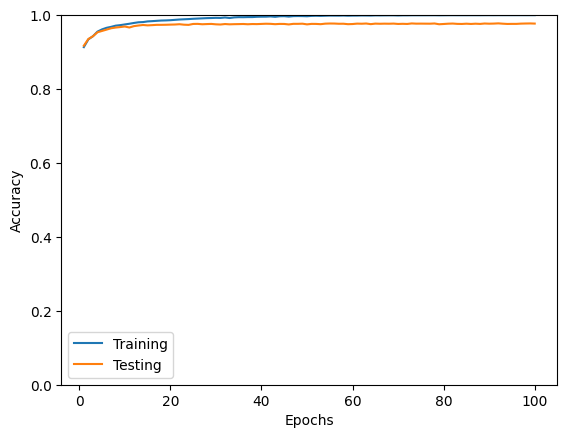

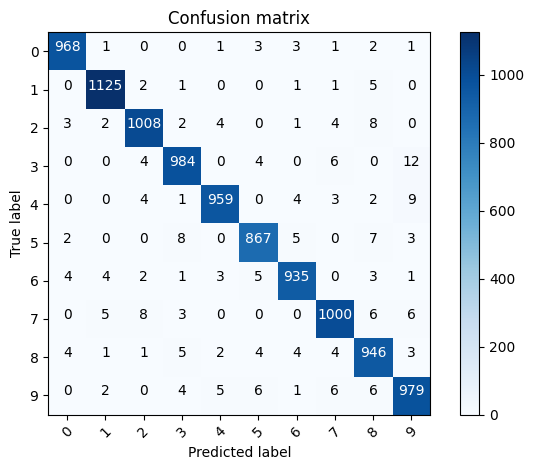

In [20]:
# Train the network
train_acc = []
test_acc = []
losses = []
loss_iterations = []
loss_itr = 0
train_predictions = np.array([])
test_predictions = np.array([])
num_batches = len(x_train) // batch_size
for epoch in range(num_epochs):
    # Shuffle data
    x_train, y_train = shuffle(x_train, y_train)
    # Mini-batch training
    for i in range(num_batches):
        # Get mini-batch
        start = i * batch_size
        end = start + batch_size
        x_batch = x_train[start:end]
        y_batch = y_train[start:end]
        # Forward propagation #probs = softmax outputs
        a1, probs = forward(x_batch, w1, b1, w2, b2)
        
        #Computing Loss
        #loss = cross_entropy_loss(probs, y_batch)
        loss = cross_entropy_loss(probs, y_batch)
        losses.append(loss)
        loss_iterations.append(loss_itr)
        loss_itr = loss_itr+1

        # Backward propagation
        dw1, db1, dw2, db2 = backward(x_batch, y_batch, a1, probs, w2)
        
        # Update weights and biases using momentum term
        m_w1 = beta1 * m_w1 + (1 - beta1) * dw1 #dw1: gradient 
        m_b1 = beta1 * m_b1 + (1 - beta1) * db1
        m_w2 = beta1 * m_w2 + (1 - beta1) * dw2
        m_b2 = beta1 * m_b2 + (1 - beta1) * db2
        w1 -= learning_rate * m_w1 
        b1 -= learning_rate * m_b1 
        w2 -= learning_rate * m_w2 
        b2 -= learning_rate * m_b2 
        
        
    # Evaluate on training set
    _, probs = forward(x_train, w1, b1, w2, b2)
    train_predictions = np.argmax(probs, axis=1)
    accuracy = np.mean(train_predictions == y_train)
    train_acc.append(accuracy)
    
        
    # Evaluate on test set
    _, probs = forward(x_test, w1, b1, w2, b2)
    test_predictions = np.argmax(probs, axis=1)
    accuracy = np.mean(test_predictions == y_test)
    test_acc.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, accuracy = {accuracy:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, train accuracy = {train_acc[-1]:.4f}, test accuracy = {test_acc[-1]:.4f}')
    
plot_learning_loss_curve(loss_itr, losses)
plot_train_validataion_acc_curve(num_epochs, train_acc, test_acc)
plot_confusion_matrix(y_test, test_predictions)

    




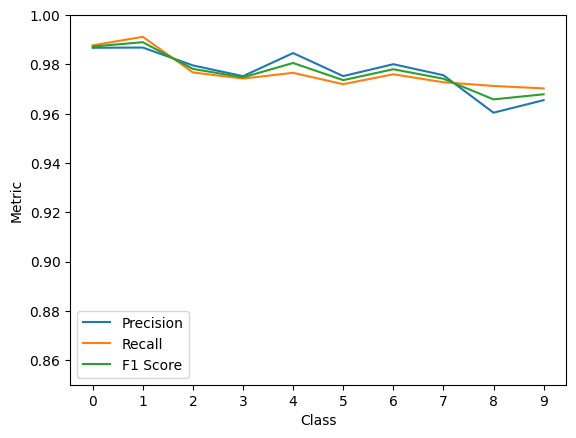

In [21]:
cm = confusion_matrix(y_test, test_predictions)
prc,recall, f1 = precision_recall_f1(cm)
plot_precision_curve(prc, recall, f1)

#Computing mean Precision , Recall, and F1 Score


##

In [22]:
mean_prec = np.mean(prc)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)
print("Precision: {:.3f} Recall: {:.3f} F1 Score: {:.3f}".format(mean_prec, mean_recall, mean_f1))

Precision: 0.977 Recall: 0.977 F1 Score: 0.977
